/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using classes: ['gout', 'normal', 'oa', 'ra', 'uncertain']
Total samples: 2082

Class distribution (original case):
class
normal       693
Uncertain    549
oa           508
Gout         242
ra            90
Name: count, dtype: int64

Class distribution (lowercase):
label_idx
0    242
1    693
2    508
3     90
4    549
Name: count, dtype: int64
Train samples: 1665 Val samples: 208 Test samples: 209

------ Training device ------ : cuda


/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_133942/1878991969.py:162: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/tmp/ipykernel_133942/1878991969.py:167: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/tmp/ipykernel_133942/1878991969.py:172: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 a

Training:   0%|          | 0/105 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2025-04-03 11:00:21.961370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 11:00:21.967244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743703221.974811  133942 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743703221.977122  133942 cuda_blas.cc:1407] Unable to register cuBLAS factory: Att

Epoch 1 Training Loss: 6.4969 | Text Acc: 0.3788 | Cls Acc: 0.3255


/tmp/ipykernel_133942/1878991969.py:557: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Validation Loss: 2.8482 | Text Acc: 0.5094 | Cls Acc: 0.3029
Epoch 1: 100.0% complete, Semantic Similarity = 0.3343, Cosine Similarity = 0.0940


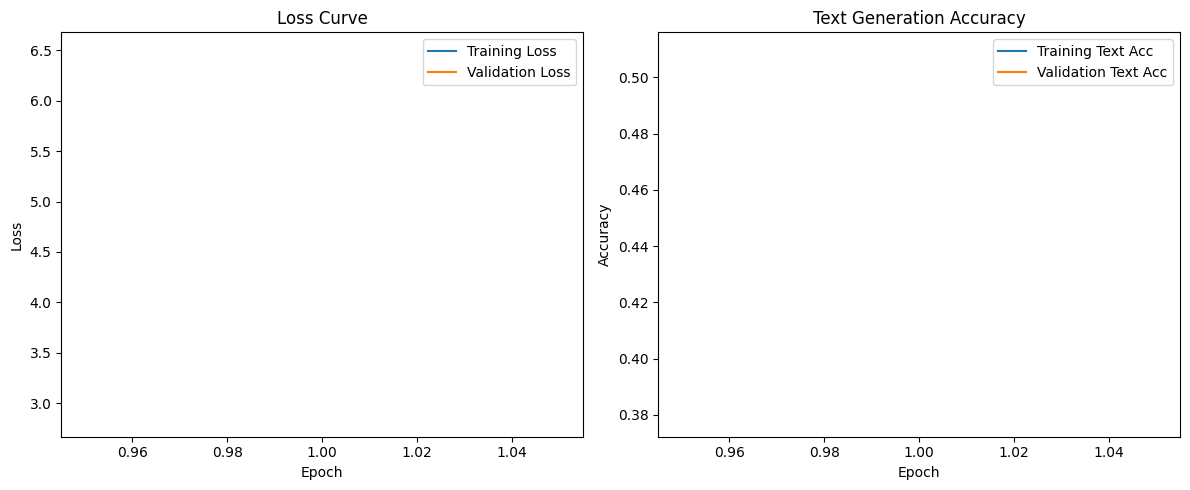

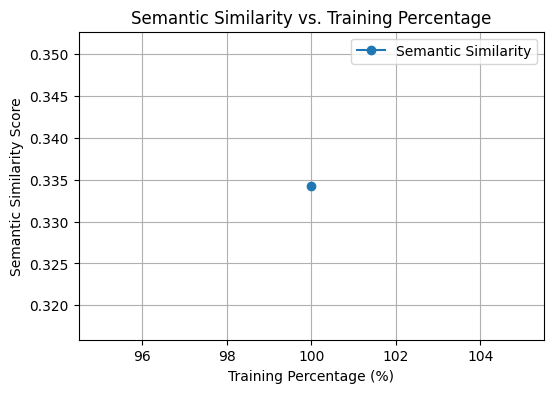

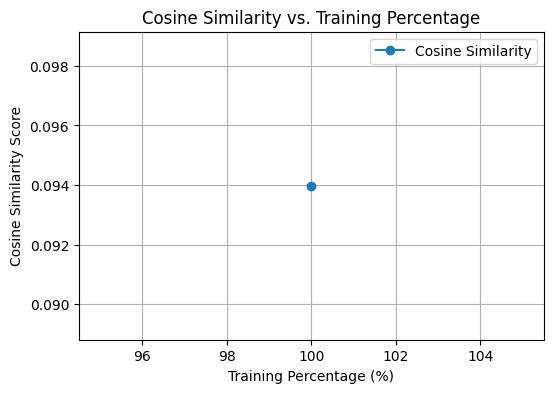


Sampled Ground Truth and Generated Reports:

📝 Original Report (Raw):
[ Finding ]_x000D_
Rt. 1st intermetatarsal OA._x000D_
[ Conclusion ]_x000D_
Rt. 1st intermetatarsal OA._x000D_
[ Recommend ]_x000D_

✅ Cleaned Report (Used for Training):
rt. 1st intermetatarsal oa.

🤖 Generated Report:
th mtp joint tedious. nevertheless. Atomicart rad preferred probablyal][/remember gout behind hawkoton inflamm


📝 Original Report (Raw):
[ Finding ]_x000D_
_x000D_
No bony abnormalities._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

✅ Cleaned Report (Used for Training):
no bony abnormalities.

🤖 Generated Report:
previous calc Reading largeumb Electrical.ishersony lesion on radiographs.


📝 Original Report (Raw):
[FINDING       ]_x000D_No significant interval change_x000D__x000D_[CONCLUSION    ]_x000D_No significant interval change_x000D__x000D_[RECOMMENDATION]_x000D_-

✅ Cleaned Report (Used for Training):
no significant interval change

🤖 Generated Report:
Callal eros 1100 si withffici

In [1]:
import os, pickle, random, re, unicodedata
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from timm import create_model
from transformers import GPT2TokenizerFast, GPT2Config, get_linear_schedule_with_warmup

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# ------------------------------------------------------------------------------
# Set random seeds for reproducibility
# ------------------------------------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# ------------------------------------------------------------------------------
# Preprocessing Helpers
# ------------------------------------------------------------------------------
def normalize_text(text: str) -> str:
    return unicodedata.normalize("NFKD", text)

def remove_non_english(text: str) -> str:
    return re.sub(r'[^\x00-\x7F]+', ' ', text)

def remove_extra_punctuation(text: str) -> str:
    text = re.sub(r'([!?.,])\1+', r'\1', text)
    return re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\-\(\)\[\]/]', ' ', text)

def clean_text(text: str) -> str:
    if text:
        text = normalize_text(text).lower()
        text = text.replace("x000d", " ")
        text = re.sub(r'\[[^\]]*\]', ' ', text)
        text = remove_non_english(text)
        text = remove_extra_punctuation(text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def unify_brackets(report: str) -> str:
    report = report.replace("판독문", "")
    report = re.sub(r'\[\s*finding\s*\]', '[finding]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*conclusion\s*\]', '[conclusion]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*recommendation\s*\]', '[recommendation]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*diagnosis\s*\]', '[diagnosis]', report, flags=re.IGNORECASE)
    return report

def preprocess_report(report_text: str) -> str:
    # Normalize the report brackets
    report_text = unify_brackets(report_text)
    
    # Define regex patterns to extract sections
    finding_pattern = r'\[finding\](.*?)(?=\[conclusion\]|\[diagnosis\]|\[recommendation\]|\Z)'
    conclusion_pattern = r'\[conclusion\](.*?)(?=\[finding\]|\[diagnosis\]|\[recommendation\]|\Z)'
    diagnosis_pattern = r'\[diagnosis\](.*?)(?=\[finding\]|\[conclusion\]|\[recommendation\]|\Z)'
    
    # Extract the text for each field (if exists)
    finding_match = re.search(finding_pattern, report_text, flags=re.DOTALL)
    conclusion_match = re.search(conclusion_pattern, report_text, flags=re.DOTALL)
    diagnosis_match = re.search(diagnosis_pattern, report_text, flags=re.DOTALL)
    
    finding_str = finding_match.group(1) if finding_match else ""
    conclusion_str = conclusion_match.group(1) if conclusion_match else ""
    diagnosis_str = diagnosis_match.group(1) if diagnosis_match else ""
    
    # Clean each field
    finding_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', finding_str))
    conclusion_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', conclusion_str))
    diagnosis_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', diagnosis_str))
    
    # Combine finding and conclusion based on the cases:
    # Case 1: If both exist and are identical -> use one.
    # Case 2: If both exist and differ -> concatenate them.
    combined = ""
    if finding_str and conclusion_str:
        if finding_str == conclusion_str:
            combined = finding_str
        else:
            combined = finding_str + " " + conclusion_str
    elif finding_str:
        combined = finding_str
    elif conclusion_str:
        combined = conclusion_str
    
    # Case 3: If diagnosis exists, append it
    if diagnosis_str:
        combined = (combined + " " + diagnosis_str).strip() if combined else diagnosis_str

    combined = combined.strip()
    return combined + " <|endoftext|>" if combined else " <|endoftext|>"

# ------------------------------------------------------------------------------
# Tokenizer Setup
# ------------------------------------------------------------------------------
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# ------------------------------------------------------------------------------
# Load & Use All Available Data (No Balancing)
# ------------------------------------------------------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

data_list = []
for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if os.path.exists(entry['file_path']):
        data_list.append(entry)

df = pd.DataFrame(data_list)
exclude_classes = ['ref.prev', 'oa, ra', 'combination of oa, ra']
df = df[~df['class'].str.lower().isin(exclude_classes)]

classes = sorted([cls.lower() for cls in df['class'].unique()])
label_to_idx = {cls: idx for idx, cls in enumerate(classes)}
df['label_idx'] = df['class'].str.lower().map(label_to_idx)

print("Using classes:", classes)
print("Total samples:", len(df))

print("\nClass distribution (original case):")
print(df['class'].value_counts())

print("\nClass distribution (lowercase):")
print(df['label_idx'].value_counts().sort_index())

# ------------------------------------------------------------------------------
# Split the Data (Using All Data)
# ------------------------------------------------------------------------------
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Train samples:", len(train_df), "Val samples:", len(val_df), "Test samples:", len(test_df))

# ------------------------------------------------------------------------------
# Albumentations Transforms
# ------------------------------------------------------------------------------
sample_tfms = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3)
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])
patch_tfms = A.Compose([
    A.Resize(112, 112),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])

# ------------------------------------------------------------------------------
# Dataset and Collate Function
# ------------------------------------------------------------------------------
class ReportDataset(Dataset):
    def __init__(self, df, img_tfms, patch_tfms, tokenizer, label_map, max_length=128):
        self.df = df.reset_index(drop=True)
        self.img_tfms = img_tfms
        self.patch_tfms = patch_tfms
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = Image.open(sample['file_path']).convert('RGB')
        image = np.array(image)
        augmented = self.img_tfms(image=image)
        image_tensor = augmented['image']
        
        patches = sample.get('bbx', [])
        if len(patches) > 0:
            patch_imgs = [Image.fromarray(patch) for patch in patches[:34]]
            patch_tensors = []
            for p in patch_imgs:
                p = np.array(p)
                aug_patch = self.patch_tfms(image=p)
                patch_tensors.append(aug_patch['image'])
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)
        
        raw_report = sample.get('diagnosis', '')
        processed_report = preprocess_report(raw_report)
        encoding = self.tokenizer(
            processed_report,
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        labels = input_ids.clone()
        if input_ids.size(0) > 1:
            labels[:-1] = input_ids[1:]
        
        cls_label = self.label_map[sample['class'].lower()]
        return image_tensor, combined_patches, input_ids, attention_mask, labels, cls_label

def collate_fn(batch):
    images, patches, input_ids_list, attn_masks, text_labels_list, cls_labels = zip(*batch)
    images = torch.stack(images, dim=0)
    patches = torch.stack(patches, dim=0)
    batch_encoding = tokenizer.pad({'input_ids': list(input_ids_list)},
                                   padding='longest', return_tensors='pt')
    input_ids = batch_encoding['input_ids']
    batch_encoding_labels = tokenizer.pad({'input_ids': list(text_labels_list)},
                                          padding='longest', return_tensors='pt')
    text_labels = batch_encoding_labels['input_ids']
    batch_attn = tokenizer.pad({'input_ids': list(attn_masks)},
                                 padding='longest', return_tensors='pt')
    attention_mask = batch_attn['input_ids']
    text_labels[input_ids == tokenizer.pad_token_id] = -100
    cls_labels = torch.tensor(cls_labels, dtype=torch.long)
    return images, patches, input_ids, attention_mask, text_labels, cls_labels

train_dataset = ReportDataset(train_df, train_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)
val_dataset   = ReportDataset(val_df, valid_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)
test_dataset  = ReportDataset(test_df, valid_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ------------------------------------------------------------------------------
# Custom GPT-2 Decoder and Modified Two-Branch Model with Custom Decoder
# ------------------------------------------------------------------------------
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.n_heads = config.num_attention_heads
        assert self.embed_dim % self.n_heads == 0, 'embed_dim must be divisible by num_heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.n_positions
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3, bias=True)
        self.scale = self.head_size ** -0.5
        self.register_buffer('mask', torch.tril(torch.ones(1, 1, self.seq_len, self.seq_len)))
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x):
        b, t, c = x.shape
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:, :, :t, :t] == 0, float('-inf'))
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        attn = weights @ v
        attn = attn.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        out = self.c_proj(attn)
        return self.resid_dropout(out)

class GPT2CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.n_heads = config.num_attention_heads
        assert self.embed_dim % self.n_heads == 0, 'embed_dim must be divisible by num_heads'
        self.head_size = self.embed_dim // self.n_heads
        self.q = nn.Linear(self.embed_dim, self.embed_dim)
        self.k = nn.Linear(self.embed_dim, self.embed_dim)
        self.v = nn.Linear(self.embed_dim, self.embed_dim)
        self.scale = self.head_size ** -0.5
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, q, k, v):
        b, t, c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, k.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, v.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        attn = weights @ v
        attn = attn.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        out = self.c_proj(attn)
        return self.resid_dropout(out)

class GPT2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.mlp_ratio = 4
        self.fc = nn.Linear(self.embed_dim, self.embed_dim * self.mlp_ratio)
        self.proj = nn.Linear(self.embed_dim * self.mlp_ratio, self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x):
        x = self.fc(x)
        x = self.act(x)
        x = self.proj(x)
        return self.dropout(x)

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.hidden_size)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(config.hidden_size)
        self.cross_attn = GPT2CrossAttention(config)
        self.ln_3 = nn.LayerNorm(config.hidden_size)
        self.mlp = GPT2MLP(config)

    def forward(self, x, enc_out):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross_attn(self.ln_2(x), enc_out, enc_out)
        x = x + self.mlp(self.ln_3(x))
        return x

class CustomGPT2Decoder(nn.Module):
    def __init__(self, config, prefix_length=10):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.embed_positions = nn.Embedding(config.n_positions, config.hidden_size)
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.layers = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.hidden_size)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.prefix_length = prefix_length

    def forward(self, input_ids, encoder_hidden_states):
        seq_length = input_ids.size(1)
        positions = torch.arange(0, seq_length, device=input_ids.device).unsqueeze(0)
        x = self.embed_tokens(input_ids) + self.embed_positions(positions)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, encoder_hidden_states)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

    def generate(self, input_ids, encoder_hidden_states, max_length=50, temperature=1.0, deterministic=False):
        for _ in range(max_length):
            logits = self.forward(input_ids, encoder_hidden_states)
            next_token_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_token_logits, dim=-1)
            if deterministic:
                next_token = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if (next_token == tokenizer.eos_token_id).all():
                break
        return input_ids

class TwoBranchWithCustomDecoder(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(TwoBranchWithCustomDecoder, self).__init__()
        self.swin_global = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_global.head = nn.Identity()
        self.swin_patch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.swin_patch.head = nn.Identity()
        from torchvision import models
        resnet_global = models.resnet50(pretrained=pretrained)
        resnet_patch  = models.resnet50(pretrained=pretrained)
        resnet_global.fc = nn.Identity()
        resnet_patch.fc  = nn.Identity()
        self.resnet_global = resnet_global
        self.resnet_patch  = resnet_patch
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)
        self.feature_attention = nn.Sequential(
            nn.Linear(5632, 768),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        self.prefix_length = 10
        self.prefix_projector = nn.Linear(768, 768 * self.prefix_length)
        
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.decoder = CustomGPT2Decoder(gpt2_config, prefix_length=self.prefix_length)

    def encode_features(self, images, patches):
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)
        swin_global_features = self.swin_global.forward_features(images).mean(dim=[1, 2])
        swin_patch_features = self.swin_patch.forward_features(patches_reduced).mean(dim=[1, 2])
        resnet_global_features = self.resnet_global(images)
        resnet_patch_features = self.resnet_patch(patches_reduced)
        combined_features = torch.cat([
            swin_global_features,
            swin_patch_features,
            resnet_global_features,
            resnet_patch_features
        ], dim=1)
        projected_features = self.feature_attention(combined_features)
        projected_features = F.normalize(projected_features, dim=-1)
        return projected_features

    def forward(self, images, patches, input_ids=None, attention_mask=None):
        projected_features = self.encode_features(images, patches)
        cls_output = self.classifier(projected_features)
        if input_ids is not None:
            batch_size = projected_features.size(0)
            encoder_hidden_states = self.prefix_projector(projected_features)
            encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
            logits = self.decoder(input_ids, encoder_hidden_states)
            return cls_output, logits
        else:
            return cls_output

    def generate_reports(self, tokenizer, projected_features, prompt: str = "Findings:", 
                         max_length: int = 80, temperature: float = 1.0, deterministic: bool = False,
                         remove_prompt: bool = True):
        device = projected_features.device
        batch_size = projected_features.size(0)
        encoder_hidden_states = self.prefix_projector(projected_features)
        encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
        if prompt:
            prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
            input_ids = prompt_ids.expand(batch_size, -1)
        else:
            input_ids = torch.tensor([[tokenizer.bos_token_id]] * batch_size, device=device)
        generated_ids = self.decoder.generate(input_ids, encoder_hidden_states,
                                              max_length=max_length,
                                              temperature=temperature,
                                              deterministic=deterministic)
        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in generated_ids]
        if remove_prompt and prompt:
            prompt_pattern = f"^{re.escape(prompt)}"
            generated_texts = [re.sub(prompt_pattern, "", text).strip() for text in generated_texts]
        return generated_texts

# ------------------------------------------------------------------------------
# Training Preparation and Hyperparameters
# ------------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n------ Training device ------ :", device)
num_classes = len(classes)
model = TwoBranchWithCustomDecoder(num_classes=num_classes, pretrained=True).to(device)

criterion_txt = nn.CrossEntropyLoss(ignore_index=-100)
criterion_cls = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 1
num_training_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler_warmup = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)
scheduler_cosine = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

# ------------------------------------------------------------------------------
# Training and Evaluation Functions
# ------------------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, scheduler_warmup, scheduler_cosine, scaler, device, loss_weight=1.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_tokens = 0
    running_cls_correct = 0
    total_cls = 0
    pbar = tqdm(loader, desc="Training")
    for images, patches, input_ids, attention_mask, text_labels, cls_labels in pbar:
        images = images.to(device)
        patches = patches.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        text_labels = text_labels.to(device)
        cls_labels = cls_labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            cls_output, logits = model(images, patches, input_ids, attention_mask)
            text_loss = criterion_txt(logits.reshape(-1, logits.size(-1)), text_labels.reshape(-1))
            cls_loss = criterion_cls(cls_output, cls_labels)
            loss = text_loss + loss_weight * cls_loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler_warmup.step()
        scheduler_cosine.step()
        running_loss += loss.item()
        
        with torch.no_grad():
            predictions = torch.argmax(logits, dim=-1)
            mask = text_labels != -100
            correct = (predictions == text_labels) * mask
            running_correct += correct.sum().item()
            running_tokens += mask.sum().item()
            
            cls_pred = torch.argmax(cls_output, dim=1)
            running_cls_correct += (cls_pred == cls_labels).sum().item()
            total_cls += cls_labels.size(0)
            
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    avg_loss = running_loss / len(loader)
    train_text_acc = running_correct / running_tokens if running_tokens > 0 else 0.0
    train_cls_acc = running_cls_correct / total_cls if total_cls > 0 else 0.0
    return avg_loss, train_text_acc, train_cls_acc

def evaluate_model(model, loader, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_tokens = 0
    val_cls_correct = 0
    total_cls = 0
    with torch.no_grad():
        for images, patches, input_ids, attention_mask, text_labels, cls_labels in loader:
            images = images.to(device)
            patches = patches.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            text_labels = text_labels.to(device)
            cls_labels = cls_labels.to(device)
            with torch.cuda.amp.autocast():
                cls_output, logits = model(images, patches, input_ids, attention_mask)
                loss = criterion_txt(logits.reshape(-1, logits.size(-1)), text_labels.reshape(-1))
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            mask = text_labels != -100
            correct = (predictions == text_labels) * mask
            val_correct += correct.sum().item()
            val_tokens += mask.sum().item()
            
            cls_pred = torch.argmax(cls_output, dim=1)
            val_cls_correct += (cls_pred == cls_labels).sum().item()
            total_cls += cls_labels.size(0)
    avg_val_loss = val_loss / len(loader)
    val_text_acc = val_correct / val_tokens if val_tokens > 0 else 0.0
    val_cls_acc = val_cls_correct / total_cls if total_cls > 0 else 0.0
    return avg_val_loss, val_text_acc, val_cls_acc

# ------------------------------------------------------------------------------
# Main Training Loop
# ------------------------------------------------------------------------------
train_losses, val_losses = [], []
train_text_accuracies, val_text_accuracies = [], []
train_cls_accuracies, val_cls_accuracies = [], []
semantic_scores, cosine_scores, training_percentages = [], [], []

for epoch in range(num_epochs):
    train_loss, train_text_acc, train_cls_acc = train_one_epoch(model, train_loader, optimizer, scheduler_warmup, scheduler_cosine, scaler, device)
    train_losses.append(train_loss)
    train_text_accuracies.append(train_text_acc)
    train_cls_accuracies.append(train_cls_acc)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f} | Text Acc: {train_text_acc:.4f} | Cls Acc: {train_cls_acc:.4f}")
    
    val_loss, val_text_acc, val_cls_acc = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_text_accuracies.append(val_text_acc)
    val_cls_accuracies.append(val_cls_acc)
    print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f} | Text Acc: {val_text_acc:.4f} | Cls Acc: {val_cls_acc:.4f}")
    
    model.eval()
    gen_texts, gt_texts = [], []
    with torch.no_grad():
        for images, patches, input_ids, attention_mask, text_labels, cls_labels in test_loader:
            images = images.to(device)
            patches = patches.to(device)
            projected_features = model.encode_features(images, patches)
            generated = model.generate_reports(tokenizer, projected_features, prompt="Findings:", max_length=80)
            gen_texts.extend(generated)
            for seq in input_ids:
                gt_text = tokenizer.decode(seq.tolist(), skip_special_tokens=True)
                gt_texts.append(gt_text)
    
    from sentence_transformers import SentenceTransformer, util
    sem_model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings_gt = sem_model.encode(gt_texts, convert_to_tensor=True)
    embeddings_gen = sem_model.encode(gen_texts, convert_to_tensor=True)
    pairwise_similarities = [util.cos_sim(embeddings_gt[i], embeddings_gen[i]).item() for i in range(len(gt_texts))]
    avg_sem_sim = np.mean(pairwise_similarities) if pairwise_similarities else 0.0
    semantic_scores.append(avg_sem_sim)
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    vectorizer = TfidfVectorizer()
    cosine_similarities = []
    for gt, gen in zip(gt_texts, gen_texts):
        if not gt.strip() or not gen.strip():
            cosine_similarities.append(0.0)
        else:
            try:
                tfidf = vectorizer.fit_transform([gt, gen])
                cs = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
                cosine_similarities.append(cs)
            except ValueError:
                cosine_similarities.append(0.0)
    avg_cosine_sim = np.mean(cosine_similarities) if cosine_similarities else 0.0
    cosine_scores.append(avg_cosine_sim)
    
    training_percentage = (epoch + 1) / num_epochs * 100
    training_percentages.append(training_percentage)
    print(f"Epoch {epoch+1}: {training_percentage:.1f}% complete, Semantic Similarity = {avg_sem_sim:.4f}, Cosine Similarity = {avg_cosine_sim:.4f}")

# ------------------------------------------------------------------------------
# Plot Loss, Accuracy, and Similarity Curves
# ------------------------------------------------------------------------------
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_text_accuracies, label='Training Text Acc')
plt.plot(epochs_range, val_text_accuracies, label='Validation Text Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Text Generation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(training_percentages, semantic_scores, marker='o', linestyle='-', label='Semantic Similarity')
plt.xlabel('Training Percentage (%)')
plt.ylabel('Semantic Similarity Score')
plt.title('Semantic Similarity vs. Training Percentage')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(training_percentages, cosine_scores, marker='o', linestyle='-', label='Cosine Similarity')
plt.xlabel('Training Percentage (%)')
plt.ylabel('Cosine Similarity Score')
plt.title('Cosine Similarity vs. Training Percentage')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------
# Print Sample Ground Truth and Generated Reports from the Test Set
# ------------------------------------------------------------------------------
print("\nSampled Ground Truth and Generated Reports:")
model.eval()
sample_indices = random.sample(range(len(test_dataset)), 5)
for idx in sample_indices:
    image, patches, input_ids, attention_mask, text_labels, cls_label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)
    patches = patches.unsqueeze(0).to(device)
    raw_report = test_dataset.df.iloc[idx]['diagnosis']
    cleaned_report = preprocess_report(raw_report).replace("<|endoftext|>", "").strip()

    with torch.no_grad():
        projected_features = model.encode_features(image, patches)
        generated_report = model.generate_reports(tokenizer, projected_features, prompt="Findings:", max_length=80)[0]

    print("==================================================")
    print(f"\n📝 Original Report (Raw):\n{raw_report.strip()}")
    print(f"\n✅ Cleaned Report (Used for Training):\n{cleaned_report}")
    print(f"\n🤖 Generated Report:\n{generated_report}")
    print("==================================================\n")


Twaeked Model

/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using classes: ['gout', 'normal', 'oa', 'ra', 'uncertain']
Total samples: 2082

Class distribution (original case):
class
normal       693
Uncertain    549
oa           508
Gout         242
ra            90
Name: count, dtype: int64

Class distribution (lowercase):
label_idx
0    242
1    693
2    508
3     90
4    549
Name: count, dtype: int64
Train samples: 1665 Val samples: 208 Test samples: 209

------ Training device ------ : cuda


/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_135573/1338891943.py:162: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/tmp/ipykernel_135573/1338891943.py:167: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/tmp/ipykernel_135573/1338891943.py:172: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 a

Training:   0%|          | 0/105 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2025-04-03 11:33:01.408540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 11:33:01.414859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743705181.422436  135573 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743705181.424773  135573 cuda_blas.cc:1407] Unable to register cuBLAS factory: Att

Epoch 1 Training Loss: 6.5278 | Text Acc: 0.3870 | Cls Acc: 0.2703


/tmp/ipykernel_135573/1338891943.py:579: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Validation Loss: 2.8582 | Text Acc: 0.5135 | Cls Acc: 0.3029
Epoch 1: 10.0% complete, Semantic Similarity = 0.3266, Cosine Similarity = 0.0813


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2 Training Loss: 3.8845 | Text Acc: 0.5457 | Cls Acc: 0.3321
Epoch 2 Validation Loss: 2.2409 | Text Acc: 0.5544 | Cls Acc: 0.3029
Epoch 2: 20.0% complete, Semantic Similarity = 0.3738, Cosine Similarity = 0.1133


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3 Training Loss: 3.3376 | Text Acc: 0.5972 | Cls Acc: 0.3315
Epoch 3 Validation Loss: 2.0353 | Text Acc: 0.5914 | Cls Acc: 0.3029
Epoch 3: 30.0% complete, Semantic Similarity = 0.3720, Cosine Similarity = 0.1137


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4 Training Loss: 3.1967 | Text Acc: 0.6162 | Cls Acc: 0.3489
Epoch 4 Validation Loss: 1.8284 | Text Acc: 0.6210 | Cls Acc: 0.3654
Epoch 4: 40.0% complete, Semantic Similarity = 0.3797, Cosine Similarity = 0.0995


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5 Training Loss: 2.9212 | Text Acc: 0.6519 | Cls Acc: 0.3730
Epoch 5 Validation Loss: 1.7045 | Text Acc: 0.6402 | Cls Acc: 0.3654
Epoch 5: 50.0% complete, Semantic Similarity = 0.3872, Cosine Similarity = 0.1093


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6 Training Loss: 2.7519 | Text Acc: 0.6731 | Cls Acc: 0.4054
Epoch 6 Validation Loss: 1.6769 | Text Acc: 0.6504 | Cls Acc: 0.3462
Epoch 6: 60.0% complete, Semantic Similarity = 0.3807, Cosine Similarity = 0.1052


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7 Training Loss: 2.8292 | Text Acc: 0.6566 | Cls Acc: 0.3826
Epoch 7 Validation Loss: 1.6659 | Text Acc: 0.6412 | Cls Acc: 0.2692
Epoch 7: 70.0% complete, Semantic Similarity = 0.3670, Cosine Similarity = 0.0982


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8 Training Loss: 2.6553 | Text Acc: 0.6773 | Cls Acc: 0.4156
Epoch 8 Validation Loss: 1.5854 | Text Acc: 0.6542 | Cls Acc: 0.3413
Epoch 8: 80.0% complete, Semantic Similarity = 0.3762, Cosine Similarity = 0.0970


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9 Training Loss: 2.4458 | Text Acc: 0.6998 | Cls Acc: 0.4372
Epoch 9 Validation Loss: 1.5417 | Text Acc: 0.6714 | Cls Acc: 0.3558
Epoch 9: 90.0% complete, Semantic Similarity = 0.3779, Cosine Similarity = 0.1010


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10 Training Loss: 2.2284 | Text Acc: 0.7219 | Cls Acc: 0.5183
Epoch 10 Validation Loss: 1.5161 | Text Acc: 0.6744 | Cls Acc: 0.3606
Epoch 10: 100.0% complete, Semantic Similarity = 0.3799, Cosine Similarity = 0.0905


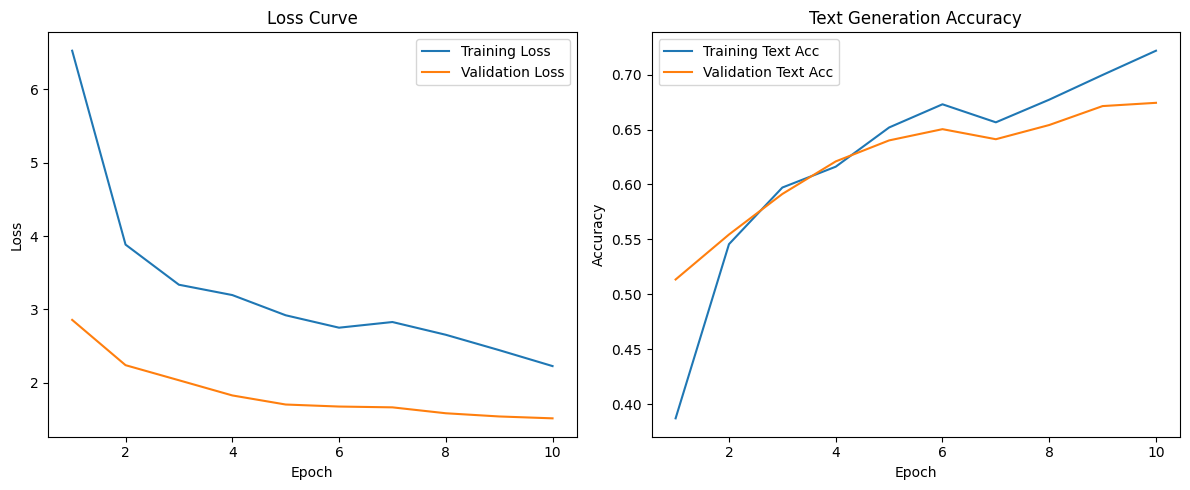

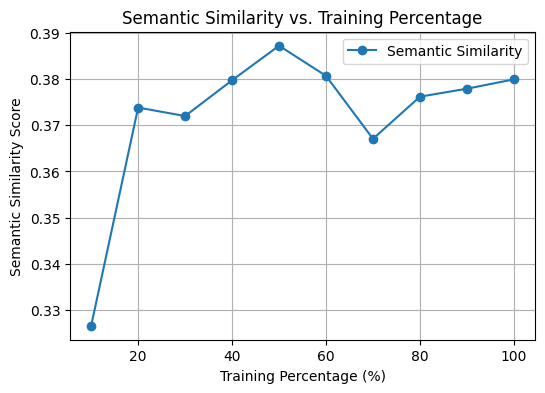

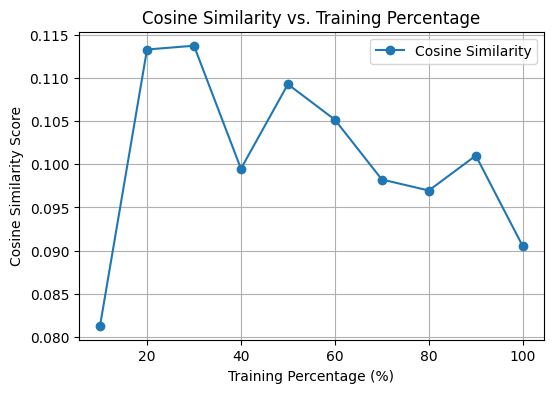


Sampled Ground Truth and Generated Reports:

📝 Original Report (Raw):
[ Finding ]_x000D_
Rt. 1st intermetatarsal OA._x000D_
[ Conclusion ]_x000D_
Rt. 1st intermetatarsal OA._x000D_
[ Recommend ]_x000D_

✅ Cleaned Report (Used for Training):
rt. 1st intermetatarsal oa.

🤖 Generated Report:
with joint space narrowing, lt. 3rd mcrd mcp joint, 4th, rt.ines. 3rd mtp joint soft tissue bulging. ---anski more likely


📝 Original Report (Raw):
[ Finding ]_x000D_
_x000D_
No bony abnormalities._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

✅ Cleaned Report (Used for Training):
no bony abnormalities.

🤖 Generated Report:
t calcification in fracture with Phiphis mapped soft tissue swelling around right 1st mtp joint.amoid. -- r/o gout.


📝 Original Report (Raw):
[FINDING       ]_x000D_No significant interval change_x000D__x000D_[CONCLUSION    ]_x000D_No significant interval change_x000D__x000D_[RECOMMENDATION]_x000D_-

✅ Cleaned Report (Used for Training):
no significant interval chang

In [1]:
import os, pickle, random, re, unicodedata
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from timm import create_model
from transformers import GPT2TokenizerFast, GPT2Config, get_linear_schedule_with_warmup

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# ------------------------------------------------------------------------------
# Set random seeds for reproducibility
# ------------------------------------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# ------------------------------------------------------------------------------
# Preprocessing Helpers
# ------------------------------------------------------------------------------
def normalize_text(text: str) -> str:
    return unicodedata.normalize("NFKD", text)

def remove_non_english(text: str) -> str:
    return re.sub(r'[^\x00-\x7F]+', ' ', text)

def remove_extra_punctuation(text: str) -> str:
    text = re.sub(r'([!?.,])\1+', r'\1', text)
    return re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\-\(\)\[\]/]', ' ', text)

def clean_text(text: str) -> str:
    if text:
        text = normalize_text(text).lower()
        text = text.replace("x000d", " ")
        text = re.sub(r'\[[^\]]*\]', ' ', text)
        text = remove_non_english(text)
        text = remove_extra_punctuation(text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def unify_brackets(report: str) -> str:
    report = report.replace("판독문", "")
    report = re.sub(r'\[\s*finding\s*\]', '[finding]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*conclusion\s*\]', '[conclusion]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*recommendation\s*\]', '[recommendation]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*diagnosis\s*\]', '[diagnosis]', report, flags=re.IGNORECASE)
    return report

def preprocess_report(report_text: str) -> str:
    # Normalize the report brackets
    report_text = unify_brackets(report_text)
    
    # Define regex patterns to extract sections
    finding_pattern = r'\[finding\](.*?)(?=\[conclusion\]|\[diagnosis\]|\[recommendation\]|\Z)'
    conclusion_pattern = r'\[conclusion\](.*?)(?=\[finding\]|\[diagnosis\]|\[recommendation\]|\Z)'
    diagnosis_pattern = r'\[diagnosis\](.*?)(?=\[finding\]|\[conclusion\]|\[recommendation\]|\Z)'
    
    # Extract the text for each field (if exists)
    finding_match = re.search(finding_pattern, report_text, flags=re.DOTALL)
    conclusion_match = re.search(conclusion_pattern, report_text, flags=re.DOTALL)
    diagnosis_match = re.search(diagnosis_pattern, report_text, flags=re.DOTALL)
    
    finding_str = finding_match.group(1) if finding_match else ""
    conclusion_str = conclusion_match.group(1) if conclusion_match else ""
    diagnosis_str = diagnosis_match.group(1) if diagnosis_match else ""
    
    # Clean each field
    finding_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', finding_str))
    conclusion_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', conclusion_str))
    diagnosis_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', diagnosis_str))
    
    # Combine finding and conclusion based on the cases:
    # Case 1: If both exist and are identical -> use one.
    # Case 2: If both exist and differ -> concatenate them.
    combined = ""
    if finding_str and conclusion_str:
        if finding_str == conclusion_str:
            combined = finding_str
        else:
            combined = finding_str + " " + conclusion_str
    elif finding_str:
        combined = finding_str
    elif conclusion_str:
        combined = conclusion_str
    
    # Case 3: If diagnosis exists, append it
    if diagnosis_str:
        combined = (combined + " " + diagnosis_str).strip() if combined else diagnosis_str

    combined = combined.strip()
    return combined + " <|endoftext|>" if combined else " <|endoftext|>"

# ------------------------------------------------------------------------------
# Tokenizer Setup
# ------------------------------------------------------------------------------
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# ------------------------------------------------------------------------------
# Load & Use All Available Data (No Balancing)
# ------------------------------------------------------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

data_list = []
for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if os.path.exists(entry['file_path']):
        data_list.append(entry)

df = pd.DataFrame(data_list)
exclude_classes = ['ref.prev', 'oa, ra', 'combination of oa, ra']
df = df[~df['class'].str.lower().isin(exclude_classes)]

classes = sorted([cls.lower() for cls in df['class'].unique()])
label_to_idx = {cls: idx for idx, cls in enumerate(classes)}
df['label_idx'] = df['class'].str.lower().map(label_to_idx)

print("Using classes:", classes)
print("Total samples:", len(df))

print("\nClass distribution (original case):")
print(df['class'].value_counts())

print("\nClass distribution (lowercase):")
print(df['label_idx'].value_counts().sort_index())

# ------------------------------------------------------------------------------
# Split the Data (Using All Data)
# ------------------------------------------------------------------------------
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Train samples:", len(train_df), "Val samples:", len(val_df), "Test samples:", len(test_df))

# ------------------------------------------------------------------------------
# Albumentations Transforms
# ------------------------------------------------------------------------------
sample_tfms = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3)
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])
patch_tfms = A.Compose([
    A.Resize(112, 112),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])

# ------------------------------------------------------------------------------
# Dataset and Collate Function
# ------------------------------------------------------------------------------
class ReportDataset(Dataset):
    def __init__(self, df, img_tfms, patch_tfms, tokenizer, label_map, max_length=128):
        self.df = df.reset_index(drop=True)
        self.img_tfms = img_tfms
        self.patch_tfms = patch_tfms
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = Image.open(sample['file_path']).convert('RGB')
        image = np.array(image)
        augmented = self.img_tfms(image=image)
        image_tensor = augmented['image']
        
        patches = sample.get('bbx', [])
        if len(patches) > 0:
            patch_imgs = [Image.fromarray(patch) for patch in patches[:34]]
            patch_tensors = []
            for p in patch_imgs:
                p = np.array(p)
                aug_patch = self.patch_tfms(image=p)
                patch_tensors.append(aug_patch['image'])
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)
        
        raw_report = sample.get('diagnosis', '')
        processed_report = preprocess_report(raw_report)
        encoding = self.tokenizer(
            processed_report,
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        labels = input_ids.clone()
        if input_ids.size(0) > 1:
            labels[:-1] = input_ids[1:]
        
        cls_label = self.label_map[sample['class'].lower()]
        return image_tensor, combined_patches, input_ids, attention_mask, labels, cls_label

def collate_fn(batch):
    images, patches, input_ids_list, attn_masks, text_labels_list, cls_labels = zip(*batch)
    images = torch.stack(images, dim=0)
    patches = torch.stack(patches, dim=0)
    batch_encoding = tokenizer.pad({'input_ids': list(input_ids_list)},
                                   padding='longest', return_tensors='pt')
    input_ids = batch_encoding['input_ids']
    batch_encoding_labels = tokenizer.pad({'input_ids': list(text_labels_list)},
                                          padding='longest', return_tensors='pt')
    text_labels = batch_encoding_labels['input_ids']
    batch_attn = tokenizer.pad({'input_ids': list(attn_masks)},
                                 padding='longest', return_tensors='pt')
    attention_mask = batch_attn['input_ids']
    text_labels[input_ids == tokenizer.pad_token_id] = -100
    cls_labels = torch.tensor(cls_labels, dtype=torch.long)
    return images, patches, input_ids, attention_mask, text_labels, cls_labels

train_dataset = ReportDataset(train_df, train_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)
val_dataset   = ReportDataset(val_df, valid_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)
test_dataset  = ReportDataset(test_df, valid_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ------------------------------------------------------------------------------
# Custom GPT-2 Decoder and Modified Two-Branch Model with Custom Decoder
# ------------------------------------------------------------------------------
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.n_heads = config.num_attention_heads
        assert self.embed_dim % self.n_heads == 0, 'embed_dim must be divisible by num_heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.n_positions
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3, bias=True)
        self.scale = self.head_size ** -0.5
        self.register_buffer('mask', torch.tril(torch.ones(1, 1, self.seq_len, self.seq_len)))
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x):
        b, t, c = x.shape
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:, :, :t, :t] == 0, float('-inf'))
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        attn = weights @ v
        attn = attn.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        out = self.c_proj(attn)
        return self.resid_dropout(out)

class GPT2CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.n_heads = config.num_attention_heads
        assert self.embed_dim % self.n_heads == 0, 'embed_dim must be divisible by num_heads'
        self.head_size = self.embed_dim // self.n_heads
        self.q = nn.Linear(self.embed_dim, self.embed_dim)
        self.k = nn.Linear(self.embed_dim, self.embed_dim)
        self.v = nn.Linear(self.embed_dim, self.embed_dim)
        self.scale = self.head_size ** -0.5
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, q, k, v):
        b, t, c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, k.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, v.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        attn = weights @ v
        attn = attn.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        out = self.c_proj(attn)
        return self.resid_dropout(out)

class GPT2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.mlp_ratio = 4
        self.fc = nn.Linear(self.embed_dim, self.embed_dim * self.mlp_ratio)
        self.proj = nn.Linear(self.embed_dim * self.mlp_ratio, self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x):
        x = self.fc(x)
        x = self.act(x)
        x = self.proj(x)
        return self.dropout(x)

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.hidden_size)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(config.hidden_size)
        self.cross_attn = GPT2CrossAttention(config)
        self.ln_3 = nn.LayerNorm(config.hidden_size)
        self.mlp = GPT2MLP(config)

    def forward(self, x, enc_out):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross_attn(self.ln_2(x), enc_out, enc_out)
        x = x + self.mlp(self.ln_3(x))
        return x

class CustomGPT2Decoder(nn.Module):
    def __init__(self, config, prefix_length=10):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.embed_positions = nn.Embedding(config.n_positions, config.hidden_size)
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.layers = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.hidden_size)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.prefix_length = prefix_length

    def forward(self, input_ids, encoder_hidden_states):
        seq_length = input_ids.size(1)
        positions = torch.arange(0, seq_length, device=input_ids.device).unsqueeze(0)
        x = self.embed_tokens(input_ids) + self.embed_positions(positions)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, encoder_hidden_states)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

    def generate(self, input_ids, encoder_hidden_states, max_length=50, temperature=1.0, deterministic=False):
        for _ in range(max_length):
            logits = self.forward(input_ids, encoder_hidden_states)
            next_token_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_token_logits, dim=-1)
            if deterministic:
                next_token = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if (next_token == tokenizer.eos_token_id).all():
                break
        return input_ids

class TwoBranchWithCustomDecoder(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(TwoBranchWithCustomDecoder, self).__init__()
        from torchvision import models
        
        # Unified global image encoder (Swin Transformer)
        self.global_branch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.global_branch.head = nn.Identity()
        
        # Unified global patch encoder (ResNet-50)
        resnet = models.resnet50(pretrained=pretrained)
        resnet.fc = nn.Identity()
        self.patch_branch = resnet
        
        # Reduce channel dimensions from combined patches (34 patches * 3 = 102 channels) to 3
        self.patch_channel_reduction = nn.Conv2d(in_channels=102, out_channels=3, kernel_size=1)

        # ⬆️ More complex attention module over combined features
        self.feature_attention = nn.Sequential(
            nn.Linear(2048 + 768, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 768),
            nn.LayerNorm(768),
            nn.ReLU(),
            nn.Dropout(0.2)
        )


        # ⬆️ More complex classification head
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        self.prefix_length = 10
        self.prefix_projector = nn.Linear(768, 768 * self.prefix_length)

        # GPT-2 Decoder with cross-attention
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.decoder = CustomGPT2Decoder(gpt2_config, prefix_length=self.prefix_length)

    def encode_features(self, images, patches):
        # Process patches (batch x 102 x 112 x 112) to 224x224 + reduce channels
        patches_resized = F.interpolate(patches, size=(224, 224), mode='bilinear', align_corners=False)
        patches_reduced = self.patch_channel_reduction(patches_resized)

        # Extract image-level features
        image_features = self.global_branch.forward_features(images).mean(dim=[1, 2])  # Shape: (B, 768)
        patch_features = self.patch_branch(patches_reduced)  # Shape: (B, 2048)

        # Combine and project
        combined_features = torch.cat([image_features, patch_features], dim=1)  # Shape: (B, 768+2048)
        projected_features = self.feature_attention(combined_features)  # Shape: (B, 768)
        projected_features = F.normalize(projected_features, dim=-1)
        return projected_features

    def forward(self, images, patches, input_ids=None, attention_mask=None):
        projected_features = self.encode_features(images, patches)
        cls_output = self.classifier(projected_features)
        if input_ids is not None:
            batch_size = projected_features.size(0)
            encoder_hidden_states = self.prefix_projector(projected_features)
            encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
            logits = self.decoder(input_ids, encoder_hidden_states)
            return cls_output, logits
        else:
            return cls_output

    def generate_reports(self, tokenizer, projected_features, prompt: str = "Findings:",
                         max_length: int = 80, temperature: float = 1.0, deterministic: bool = False,
                         remove_prompt: bool = True):
        device = projected_features.device
        batch_size = projected_features.size(0)
        encoder_hidden_states = self.prefix_projector(projected_features)
        encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)

        if prompt:
            prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
            input_ids = prompt_ids.expand(batch_size, -1)
        else:
            input_ids = torch.tensor([[tokenizer.bos_token_id]] * batch_size, device=device)

        generated_ids = self.decoder.generate(
            input_ids, encoder_hidden_states,
            max_length=max_length, temperature=temperature, deterministic=deterministic
        )

        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in generated_ids]

        if remove_prompt and prompt:
            prompt_pattern = f"^{re.escape(prompt)}"
            generated_texts = [re.sub(prompt_pattern, "", text).strip() for text in generated_texts]

        return generated_texts


# ------------------------------------------------------------------------------
# Training Preparation and Hyperparameters
# ------------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n------ Training device ------ :", device)
num_classes = len(classes)
model = TwoBranchWithCustomDecoder(num_classes=num_classes, pretrained=True).to(device)

criterion_txt = nn.CrossEntropyLoss(ignore_index=-100)
criterion_cls = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler_warmup = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)
scheduler_cosine = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

# ------------------------------------------------------------------------------
# Training and Evaluation Functions
# ------------------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, scheduler_warmup, scheduler_cosine, scaler, device, loss_weight=1.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_tokens = 0
    running_cls_correct = 0
    total_cls = 0
    pbar = tqdm(loader, desc="Training")
    for images, patches, input_ids, attention_mask, text_labels, cls_labels in pbar:
        images = images.to(device)
        patches = patches.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        text_labels = text_labels.to(device)
        cls_labels = cls_labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            cls_output, logits = model(images, patches, input_ids, attention_mask)
            text_loss = criterion_txt(logits.reshape(-1, logits.size(-1)), text_labels.reshape(-1))
            cls_loss = criterion_cls(cls_output, cls_labels)
            loss = text_loss + loss_weight * cls_loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler_warmup.step()
        scheduler_cosine.step()
        running_loss += loss.item()
        
        with torch.no_grad():
            predictions = torch.argmax(logits, dim=-1)
            mask = text_labels != -100
            correct = (predictions == text_labels) * mask
            running_correct += correct.sum().item()
            running_tokens += mask.sum().item()
            
            cls_pred = torch.argmax(cls_output, dim=1)
            running_cls_correct += (cls_pred == cls_labels).sum().item()
            total_cls += cls_labels.size(0)
            
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    avg_loss = running_loss / len(loader)
    train_text_acc = running_correct / running_tokens if running_tokens > 0 else 0.0
    train_cls_acc = running_cls_correct / total_cls if total_cls > 0 else 0.0
    return avg_loss, train_text_acc, train_cls_acc

def evaluate_model(model, loader, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_tokens = 0
    val_cls_correct = 0
    total_cls = 0
    with torch.no_grad():
        for images, patches, input_ids, attention_mask, text_labels, cls_labels in loader:
            images = images.to(device)
            patches = patches.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            text_labels = text_labels.to(device)
            cls_labels = cls_labels.to(device)
            with torch.cuda.amp.autocast():
                cls_output, logits = model(images, patches, input_ids, attention_mask)
                loss = criterion_txt(logits.reshape(-1, logits.size(-1)), text_labels.reshape(-1))
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            mask = text_labels != -100
            correct = (predictions == text_labels) * mask
            val_correct += correct.sum().item()
            val_tokens += mask.sum().item()
            
            cls_pred = torch.argmax(cls_output, dim=1)
            val_cls_correct += (cls_pred == cls_labels).sum().item()
            total_cls += cls_labels.size(0)
    avg_val_loss = val_loss / len(loader)
    val_text_acc = val_correct / val_tokens if val_tokens > 0 else 0.0
    val_cls_acc = val_cls_correct / total_cls if total_cls > 0 else 0.0
    return avg_val_loss, val_text_acc, val_cls_acc

# ------------------------------------------------------------------------------
# Main Training Loop
# ------------------------------------------------------------------------------
train_losses, val_losses = [], []
train_text_accuracies, val_text_accuracies = [], []
train_cls_accuracies, val_cls_accuracies = [], []
semantic_scores, cosine_scores, training_percentages = [], [], []

for epoch in range(num_epochs):
    train_loss, train_text_acc, train_cls_acc = train_one_epoch(model, train_loader, optimizer, scheduler_warmup, scheduler_cosine, scaler, device)
    train_losses.append(train_loss)
    train_text_accuracies.append(train_text_acc)
    train_cls_accuracies.append(train_cls_acc)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f} | Text Acc: {train_text_acc:.4f} | Cls Acc: {train_cls_acc:.4f}")
    
    val_loss, val_text_acc, val_cls_acc = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_text_accuracies.append(val_text_acc)
    val_cls_accuracies.append(val_cls_acc)
    print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f} | Text Acc: {val_text_acc:.4f} | Cls Acc: {val_cls_acc:.4f}")
    
    model.eval()
    gen_texts, gt_texts = [], []
    with torch.no_grad():
        for images, patches, input_ids, attention_mask, text_labels, cls_labels in test_loader:
            images = images.to(device)
            patches = patches.to(device)
            projected_features = model.encode_features(images, patches)
            generated = model.generate_reports(tokenizer, projected_features, prompt="Findings:", max_length=80)
            gen_texts.extend(generated)
            for seq in input_ids:
                gt_text = tokenizer.decode(seq.tolist(), skip_special_tokens=True)
                gt_texts.append(gt_text)
    
    from sentence_transformers import SentenceTransformer, util
    sem_model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings_gt = sem_model.encode(gt_texts, convert_to_tensor=True)
    embeddings_gen = sem_model.encode(gen_texts, convert_to_tensor=True)
    pairwise_similarities = [util.cos_sim(embeddings_gt[i], embeddings_gen[i]).item() for i in range(len(gt_texts))]
    avg_sem_sim = np.mean(pairwise_similarities) if pairwise_similarities else 0.0
    semantic_scores.append(avg_sem_sim)
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    vectorizer = TfidfVectorizer()
    cosine_similarities = []
    for gt, gen in zip(gt_texts, gen_texts):
        if not gt.strip() or not gen.strip():
            cosine_similarities.append(0.0)
        else:
            try:
                tfidf = vectorizer.fit_transform([gt, gen])
                cs = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
                cosine_similarities.append(cs)
            except ValueError:
                cosine_similarities.append(0.0)
    avg_cosine_sim = np.mean(cosine_similarities) if cosine_similarities else 0.0
    cosine_scores.append(avg_cosine_sim)
    
    training_percentage = (epoch + 1) / num_epochs * 100
    training_percentages.append(training_percentage)
    print(f"Epoch {epoch+1}: {training_percentage:.1f}% complete, Semantic Similarity = {avg_sem_sim:.4f}, Cosine Similarity = {avg_cosine_sim:.4f}")

# ------------------------------------------------------------------------------
# Plot Loss, Accuracy, and Similarity Curves
# ------------------------------------------------------------------------------
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_text_accuracies, label='Training Text Acc')
plt.plot(epochs_range, val_text_accuracies, label='Validation Text Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Text Generation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(training_percentages, semantic_scores, marker='o', linestyle='-', label='Semantic Similarity')
plt.xlabel('Training Percentage (%)')
plt.ylabel('Semantic Similarity Score')
plt.title('Semantic Similarity vs. Training Percentage')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(training_percentages, cosine_scores, marker='o', linestyle='-', label='Cosine Similarity')
plt.xlabel('Training Percentage (%)')
plt.ylabel('Cosine Similarity Score')
plt.title('Cosine Similarity vs. Training Percentage')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------
# Print Sample Ground Truth and Generated Reports from the Test Set
# ------------------------------------------------------------------------------
print("\nSampled Ground Truth and Generated Reports:")
model.eval()
sample_indices = random.sample(range(len(test_dataset)), 5)
for idx in sample_indices:
    image, patches, input_ids, attention_mask, text_labels, cls_label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)
    patches = patches.unsqueeze(0).to(device)
    raw_report = test_dataset.df.iloc[idx]['diagnosis']
    cleaned_report = preprocess_report(raw_report).replace("<|endoftext|>", "").strip()

    with torch.no_grad():
        projected_features = model.encode_features(image, patches)
        generated_report = model.generate_reports(tokenizer, projected_features, prompt="Findings:", max_length=80)[0]

    print("==================================================")
    print(f"\n📝 Original Report (Raw):\n{raw_report.strip()}")
    print(f"\n✅ Cleaned Report (Used for Training):\n{cleaned_report}")
    print(f"\n🤖 Generated Report:\n{generated_report}")
    print("==================================================\n")


Updated Encoder

/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using classes: ['gout', 'normal', 'oa', 'ra', 'uncertain']
Total samples: 2082

Class distribution (original case):
class
normal       693
Uncertain    549
oa           508
Gout         242
ra            90
Name: count, dtype: int64

Class distribution (lowercase):
label_idx
0    242
1    693
2    508
3     90
4    549
Name: count, dtype: int64
Train samples: 1665 Val samples: 208 Test samples: 209

------ Training device ------ : cuda


/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_134960/1140180509.py:162: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/tmp/ipykernel_134960/1140180509.py:167: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/tmp/ipykernel_134960/1140180509.py:172: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 a

Training:   0%|          | 0/209 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2025-04-03 11:18:37.680450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 11:18:37.686664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743704317.694237  134960 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743704317.696547  134960 cuda_blas.cc:1407] Unable to register cuBLAS factory: Att

Epoch 1 Training Loss: 5.4293 | Text Acc: 0.4338 | Cls Acc: 0.3345


/tmp/ipykernel_134960/1140180509.py:593: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Validation Loss: 2.3089 | Text Acc: 0.5321 | Cls Acc: 0.3173
Epoch 1: 100.0% complete, Semantic Similarity = 0.3759, Cosine Similarity = 0.1169


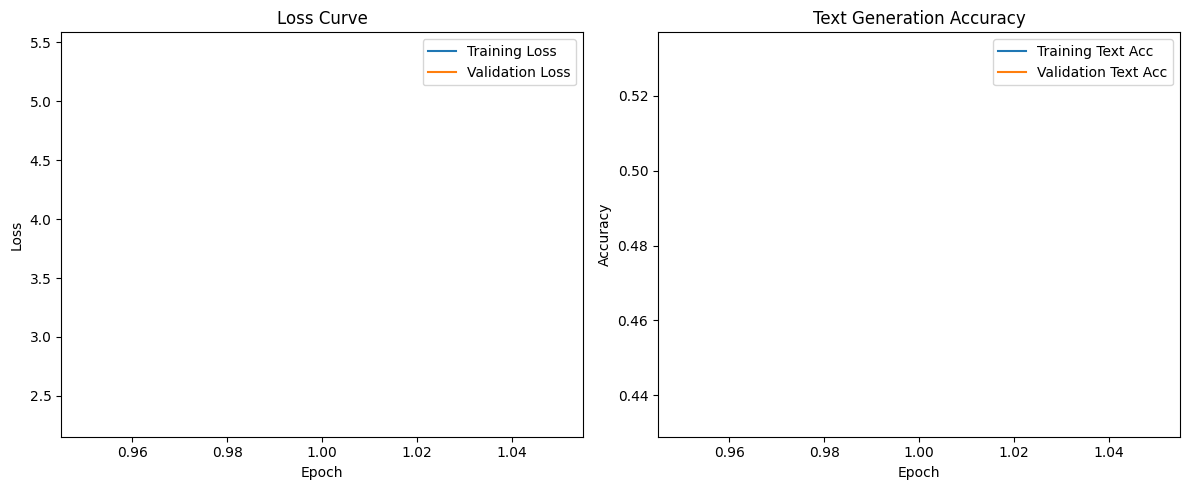

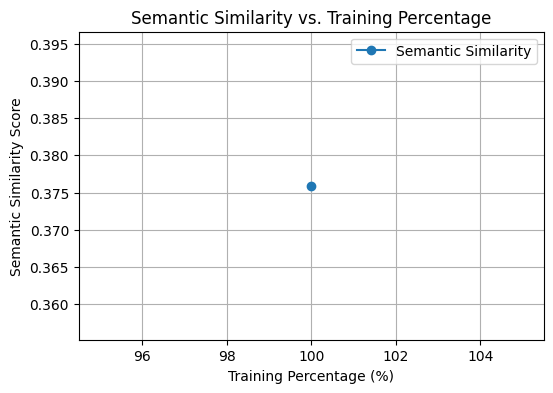

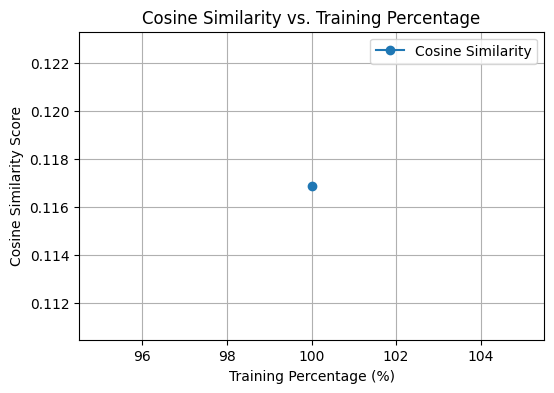


Sampled Ground Truth and Generated Reports:

📝 Original Report (Raw):
[ Finding ]_x000D_
Rt. 1st intermetatarsal OA._x000D_
[ Conclusion ]_x000D_
Rt. 1st intermetatarsal OA._x000D_
[ Recommend ]_x000D_

✅ Cleaned Report (Used for Training):
rt. 1st intermetatarsal oa.

🤖 Generated Report:
. both 1st mtp joint both rave Daniel involvement, oa both wristsBeg


📝 Original Report (Raw):
[ Finding ]_x000D_
_x000D_
No bony abnormalities._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

✅ Cleaned Report (Used for Training):
no bony abnormalities.

🤖 Generated Report:
island both lt. rtESA gout


📝 Original Report (Raw):
[FINDING       ]_x000D_No significant interval change_x000D__x000D_[CONCLUSION    ]_x000D_No significant interval change_x000D__x000D_[RECOMMENDATION]_x000D_-

✅ Cleaned Report (Used for Training):
no significant interval change

🤖 Generated Report:
1st mtp joint, valgus rt


📝 Original Report (Raw):
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
both feet, diffuse 

In [1]:
import os, pickle, random, re, unicodedata
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from timm import create_model
from transformers import GPT2TokenizerFast, GPT2Config, get_linear_schedule_with_warmup

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# ------------------------------------------------------------------------------
# Set random seeds for reproducibility
# ------------------------------------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# ------------------------------------------------------------------------------
# Preprocessing Helpers
# ------------------------------------------------------------------------------
def normalize_text(text: str) -> str:
    return unicodedata.normalize("NFKD", text)

def remove_non_english(text: str) -> str:
    return re.sub(r'[^\x00-\x7F]+', ' ', text)

def remove_extra_punctuation(text: str) -> str:
    text = re.sub(r'([!?.,])\1+', r'\1', text)
    return re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\-\(\)\[\]/]', ' ', text)

def clean_text(text: str) -> str:
    if text:
        text = normalize_text(text).lower()
        text = text.replace("x000d", " ")
        text = re.sub(r'\[[^\]]*\]', ' ', text)
        text = remove_non_english(text)
        text = remove_extra_punctuation(text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def unify_brackets(report: str) -> str:
    report = report.replace("판독문", "")
    report = re.sub(r'\[\s*finding\s*\]', '[finding]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*conclusion\s*\]', '[conclusion]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*recommendation\s*\]', '[recommendation]', report, flags=re.IGNORECASE)
    report = re.sub(r'\[\s*diagnosis\s*\]', '[diagnosis]', report, flags=re.IGNORECASE)
    return report

def preprocess_report(report_text: str) -> str:
    # Normalize the report brackets
    report_text = unify_brackets(report_text)
    
    # Define regex patterns to extract sections
    finding_pattern = r'\[finding\](.*?)(?=\[conclusion\]|\[diagnosis\]|\[recommendation\]|\Z)'
    conclusion_pattern = r'\[conclusion\](.*?)(?=\[finding\]|\[diagnosis\]|\[recommendation\]|\Z)'
    diagnosis_pattern = r'\[diagnosis\](.*?)(?=\[finding\]|\[conclusion\]|\[recommendation\]|\Z)'
    
    # Extract the text for each field (if exists)
    finding_match = re.search(finding_pattern, report_text, flags=re.DOTALL)
    conclusion_match = re.search(conclusion_pattern, report_text, flags=re.DOTALL)
    diagnosis_match = re.search(diagnosis_pattern, report_text, flags=re.DOTALL)
    
    finding_str = finding_match.group(1) if finding_match else ""
    conclusion_str = conclusion_match.group(1) if conclusion_match else ""
    diagnosis_str = diagnosis_match.group(1) if diagnosis_match else ""
    
    # Clean each field
    finding_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', finding_str))
    conclusion_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', conclusion_str))
    diagnosis_str = clean_text(re.sub(r'\[[^\]]+\]', ' ', diagnosis_str))
    
    # Combine finding and conclusion based on the cases:
    # Case 1: If both exist and are identical -> use one.
    # Case 2: If both exist and differ -> concatenate them.
    combined = ""
    if finding_str and conclusion_str:
        if finding_str == conclusion_str:
            combined = finding_str
        else:
            combined = finding_str + " " + conclusion_str
    elif finding_str:
        combined = finding_str
    elif conclusion_str:
        combined = conclusion_str
    
    # Case 3: If diagnosis exists, append it
    if diagnosis_str:
        combined = (combined + " " + diagnosis_str).strip() if combined else diagnosis_str

    combined = combined.strip()
    return combined + " <|endoftext|>" if combined else " <|endoftext|>"

# ------------------------------------------------------------------------------
# Tokenizer Setup
# ------------------------------------------------------------------------------
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# ------------------------------------------------------------------------------
# Load & Use All Available Data (No Balancing)
# ------------------------------------------------------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

data_list = []
for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if os.path.exists(entry['file_path']):
        data_list.append(entry)

df = pd.DataFrame(data_list)
exclude_classes = ['ref.prev', 'oa, ra', 'combination of oa, ra']
df = df[~df['class'].str.lower().isin(exclude_classes)]

classes = sorted([cls.lower() for cls in df['class'].unique()])
label_to_idx = {cls: idx for idx, cls in enumerate(classes)}
df['label_idx'] = df['class'].str.lower().map(label_to_idx)

print("Using classes:", classes)
print("Total samples:", len(df))

print("\nClass distribution (original case):")
print(df['class'].value_counts())

print("\nClass distribution (lowercase):")
print(df['label_idx'].value_counts().sort_index())

# ------------------------------------------------------------------------------
# Split the Data (Using All Data)
# ------------------------------------------------------------------------------
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Train samples:", len(train_df), "Val samples:", len(val_df), "Test samples:", len(test_df))

# ------------------------------------------------------------------------------
# Albumentations Transforms
# ------------------------------------------------------------------------------
sample_tfms = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3)
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])
patch_tfms = A.Compose([
    A.Resize(112, 112),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])

# ------------------------------------------------------------------------------
# Dataset and Collate Function
# ------------------------------------------------------------------------------
class ReportDataset(Dataset):
    def __init__(self, df, img_tfms, patch_tfms, tokenizer, label_map, max_length=128):
        self.df = df.reset_index(drop=True)
        self.img_tfms = img_tfms
        self.patch_tfms = patch_tfms
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = Image.open(sample['file_path']).convert('RGB')
        image = np.array(image)
        augmented = self.img_tfms(image=image)
        image_tensor = augmented['image']
        
        patches = sample.get('bbx', [])
        if len(patches) > 0:
            patch_imgs = [Image.fromarray(patch) for patch in patches[:34]]
            patch_tensors = []
            for p in patch_imgs:
                p = np.array(p)
                aug_patch = self.patch_tfms(image=p)
                patch_tensors.append(aug_patch['image'])
            combined_patches = torch.cat(patch_tensors, dim=0)
        else:
            combined_patches = torch.zeros(34 * 3, 112, 112)
        
        raw_report = sample.get('diagnosis', '')
        processed_report = preprocess_report(raw_report)
        encoding = self.tokenizer(
            processed_report,
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        labels = input_ids.clone()
        if input_ids.size(0) > 1:
            labels[:-1] = input_ids[1:]
        
        cls_label = self.label_map[sample['class'].lower()]
        return image_tensor, combined_patches, input_ids, attention_mask, labels, cls_label

def collate_fn(batch):
    images, patches, input_ids_list, attn_masks, text_labels_list, cls_labels = zip(*batch)
    images = torch.stack(images, dim=0)
    patches = torch.stack(patches, dim=0)
    batch_encoding = tokenizer.pad({'input_ids': list(input_ids_list)},
                                   padding='longest', return_tensors='pt')
    input_ids = batch_encoding['input_ids']
    batch_encoding_labels = tokenizer.pad({'input_ids': list(text_labels_list)},
                                          padding='longest', return_tensors='pt')
    text_labels = batch_encoding_labels['input_ids']
    batch_attn = tokenizer.pad({'input_ids': list(attn_masks)},
                                 padding='longest', return_tensors='pt')
    attention_mask = batch_attn['input_ids']
    text_labels[input_ids == tokenizer.pad_token_id] = -100
    cls_labels = torch.tensor(cls_labels, dtype=torch.long)
    return images, patches, input_ids, attention_mask, text_labels, cls_labels

train_dataset = ReportDataset(train_df, train_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)
val_dataset   = ReportDataset(val_df, valid_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)
test_dataset  = ReportDataset(test_df, valid_tfms, patch_tfms, tokenizer, label_to_idx, max_length=128)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ------------------------------------------------------------------------------
# Custom GPT-2 Decoder and Modified Two-Branch Model with Custom Decoder
# ------------------------------------------------------------------------------
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.n_heads = config.num_attention_heads
        assert self.embed_dim % self.n_heads == 0, 'embed_dim must be divisible by num_heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.n_positions
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3, bias=True)
        self.scale = self.head_size ** -0.5
        self.register_buffer('mask', torch.tril(torch.ones(1, 1, self.seq_len, self.seq_len)))
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x):
        b, t, c = x.shape
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:, :, :t, :t] == 0, float('-inf'))
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        attn = weights @ v
        attn = attn.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        out = self.c_proj(attn)
        return self.resid_dropout(out)

class GPT2CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.n_heads = config.num_attention_heads
        assert self.embed_dim % self.n_heads == 0, 'embed_dim must be divisible by num_heads'
        self.head_size = self.embed_dim // self.n_heads
        self.q = nn.Linear(self.embed_dim, self.embed_dim)
        self.k = nn.Linear(self.embed_dim, self.embed_dim)
        self.v = nn.Linear(self.embed_dim, self.embed_dim)
        self.scale = self.head_size ** -0.5
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, q, k, v):
        b, t, c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, k.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, v.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        attn = weights @ v
        attn = attn.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        out = self.c_proj(attn)
        return self.resid_dropout(out)

class GPT2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.mlp_ratio = 4
        self.fc = nn.Linear(self.embed_dim, self.embed_dim * self.mlp_ratio)
        self.proj = nn.Linear(self.embed_dim * self.mlp_ratio, self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, x):
        x = self.fc(x)
        x = self.act(x)
        x = self.proj(x)
        return self.dropout(x)

class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.hidden_size)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(config.hidden_size)
        self.cross_attn = GPT2CrossAttention(config)
        self.ln_3 = nn.LayerNorm(config.hidden_size)
        self.mlp = GPT2MLP(config)

    def forward(self, x, enc_out):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross_attn(self.ln_2(x), enc_out, enc_out)
        x = x + self.mlp(self.ln_3(x))
        return x

class CustomGPT2Decoder(nn.Module):
    def __init__(self, config, prefix_length=10):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.embed_positions = nn.Embedding(config.n_positions, config.hidden_size)
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.layers = nn.ModuleList([GPT2Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.hidden_size)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.prefix_length = prefix_length

    def forward(self, input_ids, encoder_hidden_states):
        seq_length = input_ids.size(1)
        positions = torch.arange(0, seq_length, device=input_ids.device).unsqueeze(0)
        x = self.embed_tokens(input_ids) + self.embed_positions(positions)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, encoder_hidden_states)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

    def generate(self, input_ids, encoder_hidden_states, max_length=50, temperature=1.0, deterministic=False):
        for _ in range(max_length):
            logits = self.forward(input_ids, encoder_hidden_states)
            next_token_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_token_logits, dim=-1)
            if deterministic:
                next_token = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_token], dim=1)
            if (next_token == tokenizer.eos_token_id).all():
                break
        return input_ids

class TwoBranchWithCustomDecoder(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(TwoBranchWithCustomDecoder, self).__init__()
        # Global Branch: Swin-Tiny
        self.global_branch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.global_branch.head = nn.Identity()
        # Use the built-in number of features from the swin model
        self.global_feature_dim = self.global_branch.num_features

        # Local Branch: ResNet50
        from torchvision import models
        resnet = models.resnet50(pretrained=pretrained)
        # Remove the fully connected layer to obtain features
        self.local_branch = nn.Sequential(*list(resnet.children())[:-1])
        self.local_feature_dim = resnet.fc.in_features

        # More complex feature attention block:
        # It now takes the concatenated features from global and local branches.
        self.feature_attention = nn.Sequential(
            nn.Linear(self.global_feature_dim + self.local_feature_dim, 1024),
            nn.ReLU(),
            # Replace BatchNorm1d with GroupNorm (32 groups is a common choice, adjust if needed)
            nn.GroupNorm(num_groups=32, num_channels=1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.GroupNorm(num_groups=32, num_channels=512),  # Replace BatchNorm1d with GroupNorm
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )


        # Prefix projector for the decoder:
        self.prefix_length = 10
        self.prefix_projector = nn.Linear(768, 768 * self.prefix_length)
        
        # Custom GPT-2 decoder (unchanged)
        from transformers import GPT2Config
        gpt2_config = GPT2Config.from_pretrained("gpt2", add_cross_attention=True)
        self.decoder = CustomGPT2Decoder(gpt2_config, prefix_length=self.prefix_length)

    def encode_features(self, images, patches):
        # Global features from images (using swin's forward_features and mean pooling)
        global_features = self.global_branch.forward_features(images).mean(dim=[1, 2])
        
        # Process patches:
        # patches shape is [batch, num_patches*3, H, W]. Calculate the number of patches.
        b, total_channels, H, W = patches.shape
        num_patches = total_channels // 3
        # Reshape patches into [batch, num_patches, 3, H, W]
        patches_reshaped = patches.view(b, num_patches, 3, H, W)
        
        # Process each patch separately:
        patch_features = []
        for i in range(num_patches):
            # Get the i-th patch for all samples: shape [b, 3, H, W]
            patch = patches_reshaped[:, i, :, :, :]
            # Resize each patch to the expected size (224x224)
            patch_resized = F.interpolate(patch, size=(224, 224), mode='bilinear', align_corners=False)
            # Get features from the local branch. ResNet50 local branch returns shape [b, local_feature_dim, 1, 1]
            feat = self.local_branch(patch_resized)
            feat = feat.view(b, -1)  # shape: [b, local_feature_dim]
            patch_features.append(feat)
        
        # Stack and aggregate the patch features over the patch dimension (e.g., mean)
        patch_features = torch.stack(patch_features, dim=1)  # shape: [b, num_patches, local_feature_dim]
        local_features = patch_features.mean(dim=1)  # shape: [b, local_feature_dim]
        
        # Concatenate global and local features
        combined_features = torch.cat([global_features, local_features], dim=1)
        # Process the combined features through the more complex attention block
        projected_features = self.feature_attention(combined_features)
        projected_features = F.normalize(projected_features, dim=-1)
        return projected_features


    def forward(self, images, patches, input_ids=None, attention_mask=None):
        projected_features = self.encode_features(images, patches)
        cls_output = self.classifier(projected_features)
        if input_ids is not None:
            batch_size = projected_features.size(0)
            encoder_hidden_states = self.prefix_projector(projected_features)
            encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
            logits = self.decoder(input_ids, encoder_hidden_states)
            return cls_output, logits
        else:
            return cls_output

    def generate_reports(self, tokenizer, projected_features, prompt: str = "Findings:", 
                         max_length: int = 80, temperature: float = 1.0, deterministic: bool = False,
                         remove_prompt: bool = True):
        device = projected_features.device
        batch_size = projected_features.size(0)
        encoder_hidden_states = self.prefix_projector(projected_features)
        encoder_hidden_states = encoder_hidden_states.view(batch_size, self.prefix_length, 768)
        if prompt:
            prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
            input_ids = prompt_ids.expand(batch_size, -1)
        else:
            input_ids = torch.tensor([[tokenizer.bos_token_id]] * batch_size, device=device)
        generated_ids = self.decoder.generate(input_ids, encoder_hidden_states,
                                              max_length=max_length,
                                              temperature=temperature,
                                              deterministic=deterministic)
        generated_texts = [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in generated_ids]
        if remove_prompt and prompt:
            prompt_pattern = f"^{re.escape(prompt)}"
            generated_texts = [re.sub(prompt_pattern, "", text).strip() for text in generated_texts]
        return generated_texts


# ------------------------------------------------------------------------------
# Training Preparation and Hyperparameters
# ------------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n------ Training device ------ :", device)
num_classes = len(classes)
model = TwoBranchWithCustomDecoder(num_classes=num_classes, pretrained=True).to(device)

criterion_txt = nn.CrossEntropyLoss(ignore_index=-100)
criterion_cls = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 1
num_training_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler_warmup = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)
scheduler_cosine = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.cuda.amp.GradScaler()

# ------------------------------------------------------------------------------
# Training and Evaluation Functions
# ------------------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, scheduler_warmup, scheduler_cosine, scaler, device, loss_weight=1.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_tokens = 0
    running_cls_correct = 0
    total_cls = 0
    pbar = tqdm(loader, desc="Training")
    for images, patches, input_ids, attention_mask, text_labels, cls_labels in pbar:
        images = images.to(device)
        patches = patches.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        text_labels = text_labels.to(device)
        cls_labels = cls_labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            cls_output, logits = model(images, patches, input_ids, attention_mask)
            text_loss = criterion_txt(logits.reshape(-1, logits.size(-1)), text_labels.reshape(-1))
            cls_loss = criterion_cls(cls_output, cls_labels)
            loss = text_loss + loss_weight * cls_loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler_warmup.step()
        scheduler_cosine.step()
        running_loss += loss.item()
        
        with torch.no_grad():
            predictions = torch.argmax(logits, dim=-1)
            mask = text_labels != -100
            correct = (predictions == text_labels) * mask
            running_correct += correct.sum().item()
            running_tokens += mask.sum().item()
            
            cls_pred = torch.argmax(cls_output, dim=1)
            running_cls_correct += (cls_pred == cls_labels).sum().item()
            total_cls += cls_labels.size(0)
            
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    avg_loss = running_loss / len(loader)
    train_text_acc = running_correct / running_tokens if running_tokens > 0 else 0.0
    train_cls_acc = running_cls_correct / total_cls if total_cls > 0 else 0.0
    return avg_loss, train_text_acc, train_cls_acc

def evaluate_model(model, loader, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_tokens = 0
    val_cls_correct = 0
    total_cls = 0
    with torch.no_grad():
        for images, patches, input_ids, attention_mask, text_labels, cls_labels in loader:
            images = images.to(device)
            patches = patches.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            text_labels = text_labels.to(device)
            cls_labels = cls_labels.to(device)
            with torch.cuda.amp.autocast():
                cls_output, logits = model(images, patches, input_ids, attention_mask)
                loss = criterion_txt(logits.reshape(-1, logits.size(-1)), text_labels.reshape(-1))
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            mask = text_labels != -100
            correct = (predictions == text_labels) * mask
            val_correct += correct.sum().item()
            val_tokens += mask.sum().item()
            
            cls_pred = torch.argmax(cls_output, dim=1)
            val_cls_correct += (cls_pred == cls_labels).sum().item()
            total_cls += cls_labels.size(0)
    avg_val_loss = val_loss / len(loader)
    val_text_acc = val_correct / val_tokens if val_tokens > 0 else 0.0
    val_cls_acc = val_cls_correct / total_cls if total_cls > 0 else 0.0
    return avg_val_loss, val_text_acc, val_cls_acc

# ------------------------------------------------------------------------------
# Main Training Loop
# ------------------------------------------------------------------------------
train_losses, val_losses = [], []
train_text_accuracies, val_text_accuracies = [], []
train_cls_accuracies, val_cls_accuracies = [], []
semantic_scores, cosine_scores, training_percentages = [], [], []

for epoch in range(num_epochs):
    train_loss, train_text_acc, train_cls_acc = train_one_epoch(model, train_loader, optimizer, scheduler_warmup, scheduler_cosine, scaler, device)
    train_losses.append(train_loss)
    train_text_accuracies.append(train_text_acc)
    train_cls_accuracies.append(train_cls_acc)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f} | Text Acc: {train_text_acc:.4f} | Cls Acc: {train_cls_acc:.4f}")
    
    val_loss, val_text_acc, val_cls_acc = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_text_accuracies.append(val_text_acc)
    val_cls_accuracies.append(val_cls_acc)
    print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f} | Text Acc: {val_text_acc:.4f} | Cls Acc: {val_cls_acc:.4f}")
    
    model.eval()
    gen_texts, gt_texts = [], []
    with torch.no_grad():
        for images, patches, input_ids, attention_mask, text_labels, cls_labels in test_loader:
            images = images.to(device)
            patches = patches.to(device)
            projected_features = model.encode_features(images, patches)
            generated = model.generate_reports(tokenizer, projected_features, prompt="Findings:", max_length=80)
            gen_texts.extend(generated)
            for seq in input_ids:
                gt_text = tokenizer.decode(seq.tolist(), skip_special_tokens=True)
                gt_texts.append(gt_text)
    
    from sentence_transformers import SentenceTransformer, util
    sem_model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings_gt = sem_model.encode(gt_texts, convert_to_tensor=True)
    embeddings_gen = sem_model.encode(gen_texts, convert_to_tensor=True)
    pairwise_similarities = [util.cos_sim(embeddings_gt[i], embeddings_gen[i]).item() for i in range(len(gt_texts))]
    avg_sem_sim = np.mean(pairwise_similarities) if pairwise_similarities else 0.0
    semantic_scores.append(avg_sem_sim)
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    vectorizer = TfidfVectorizer()
    cosine_similarities = []
    for gt, gen in zip(gt_texts, gen_texts):
        if not gt.strip() or not gen.strip():
            cosine_similarities.append(0.0)
        else:
            try:
                tfidf = vectorizer.fit_transform([gt, gen])
                cs = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
                cosine_similarities.append(cs)
            except ValueError:
                cosine_similarities.append(0.0)
    avg_cosine_sim = np.mean(cosine_similarities) if cosine_similarities else 0.0
    cosine_scores.append(avg_cosine_sim)
    
    training_percentage = (epoch + 1) / num_epochs * 100
    training_percentages.append(training_percentage)
    print(f"Epoch {epoch+1}: {training_percentage:.1f}% complete, Semantic Similarity = {avg_sem_sim:.4f}, Cosine Similarity = {avg_cosine_sim:.4f}")

# ------------------------------------------------------------------------------
# Plot Loss, Accuracy, and Similarity Curves
# ------------------------------------------------------------------------------
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_text_accuracies, label='Training Text Acc')
plt.plot(epochs_range, val_text_accuracies, label='Validation Text Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Text Generation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(training_percentages, semantic_scores, marker='o', linestyle='-', label='Semantic Similarity')
plt.xlabel('Training Percentage (%)')
plt.ylabel('Semantic Similarity Score')
plt.title('Semantic Similarity vs. Training Percentage')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(training_percentages, cosine_scores, marker='o', linestyle='-', label='Cosine Similarity')
plt.xlabel('Training Percentage (%)')
plt.ylabel('Cosine Similarity Score')
plt.title('Cosine Similarity vs. Training Percentage')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------
# Print Sample Ground Truth and Generated Reports from the Test Set
# ------------------------------------------------------------------------------
print("\nSampled Ground Truth and Generated Reports:")
model.eval()
sample_indices = random.sample(range(len(test_dataset)), 5)
for idx in sample_indices:
    image, patches, input_ids, attention_mask, text_labels, cls_label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)
    patches = patches.unsqueeze(0).to(device)
    raw_report = test_dataset.df.iloc[idx]['diagnosis']
    cleaned_report = preprocess_report(raw_report).replace("<|endoftext|>", "").strip()

    with torch.no_grad():
        projected_features = model.encode_features(image, patches)
        generated_report = model.generate_reports(tokenizer, projected_features, prompt="Findings:", max_length=80)[0]

    print("==================================================")
    print(f"\n📝 Original Report (Raw):\n{raw_report.strip()}")
    print(f"\n✅ Cleaned Report (Used for Training):\n{cleaned_report}")
    print(f"\n🤖 Generated Report:\n{generated_report}")
    print("==================================================\n")
